# Pave SFM with Python

## relevant libs

In [1]:
# SURF and SIFT is only supported in older version
# pip install opencv-contrib-python==3.4.2.16
# pip install opencv-python==3.4.2.16
import numpy as np
import glob,os,sys
import cv2 as cv 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

## load data

In [2]:
image_dir='./matlab-code/data/images/*.png'
files=glob.glob(image_dir)
print('%d images founded' % len(files))

11 images founded


In [3]:
'''
load images as gray images
'''
def read_image(path,ratio=1):
    img=cv.imread(path,0)
    dim=(int(img.shape[1]*ratio),int(img.shape[0]*ratio))
    resized=cv.resize(img,dim)
    return resized

In [4]:
images=[]
for eachimage in files:
    img=read_image(eachimage)
    images.append(img)
print(images[0].shape)

(2048, 3072)


In [18]:
# get calibration matrix
path='matlab-code/data/k/K.txt'
f=open(path,'r')
lines=f.readlines()
K=np.zeros((3,3))
for i in range(3):
    for j in range(3):
        K[i,j]=float(lines[i].split(' ')[j])
print(K)

[[2.75948e+03 0.00000e+00 1.52069e+03]
 [0.00000e+00 2.76416e+03 1.00681e+03]
 [0.00000e+00 0.00000e+00 1.00000e+00]]


## extract features using SURF

### play with SURF on a single image

In [5]:
# Here I set Hessian Threshold to 400
surf = cv.xfeatures2d.SURF_create(400)
sample_img=images[0]
%time kp, des = surf.detectAndCompute(sample_img,None)
print(len(kp))

CPU times: user 4.9 s, sys: 246 ms, total: 5.15 s
Wall time: 1.82 s
8136


In [6]:
# Here I set Hessian Threshold to 400
# extended: true - use extended 128-element descriptors; false - use 64-element descriptors
surf = cv.xfeatures2d.SURF_create(hessianThreshold=1000,extended=True)
sample_img=images[0]
kp, des = surf.detectAndCompute(sample_img,None)
print(len(kp))

2547


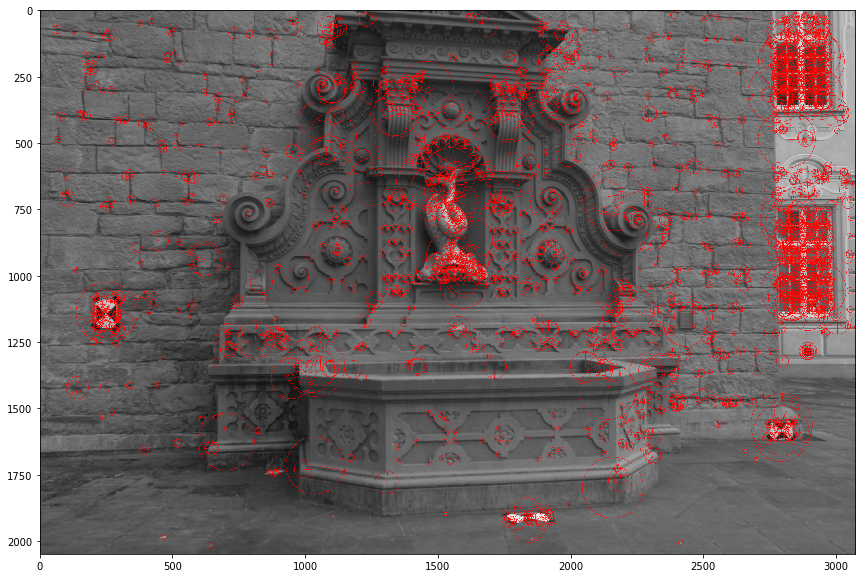

In [7]:
img2 = cv.drawKeypoints(sample_img,kp,None,(255,0,0),4)
plt.figure(figsize=(20,10))
plt.imshow(img2)

In [8]:
print(len(kp),des.shape)

2547 (2547, 128)


### compute keypoints and descriptors for all the images

In [9]:
keypoints,descriptors=[],[]
surf = cv.xfeatures2d.SURF_create(hessianThreshold=1000,extended=True)
for image in images:
    kp, des = surf.detectAndCompute(image,None)
    keypoints.append(kp)
    descriptors.append(des)

<font color='red'> This part could be optimized using multi-processing

## match keypoints

### play with paired images first

In [10]:
# default brute force matcher with ratio test
bf = cv.BFMatcher()
img1,img2=images[0],images[1]
des1,des2=descriptors[0],descriptors[1]
kp1,kp2=keypoints[0],keypoints[1]
matches = bf.knnMatch(des1,des2,k=2)

In [11]:
print(len(matches),len(matches[0]))

2547 2


The result of matches = bf.match(des1,des2) line is a list of DMatch objects. This DMatch object has following attributes:

- DMatch.distance - Distance between descriptors. The lower, the better it is.
- DMatch.trainIdx - Index of the descriptor in train descriptors
- DMatch.queryIdx - Index of the descriptor in query descriptors
- DMatch.imgIdx - Index of the train image.

584


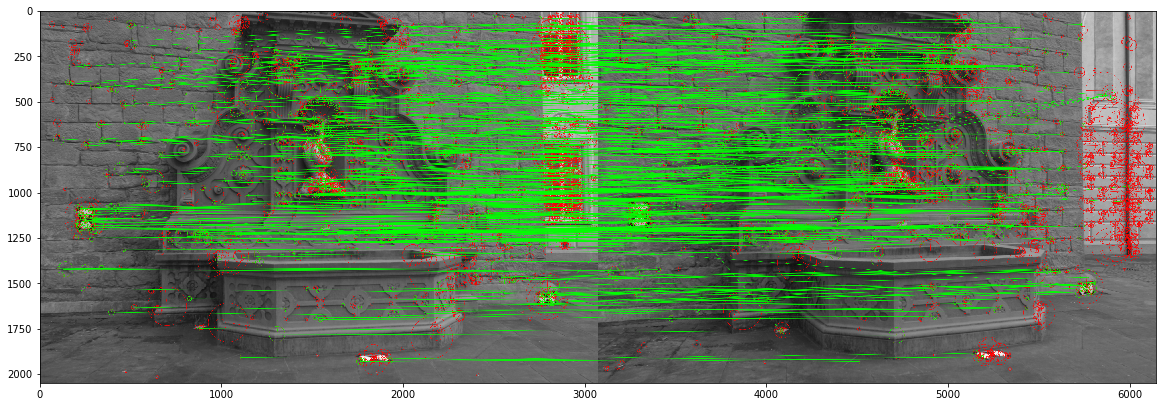

In [12]:
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
print(len(good))
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=4,matchColor = (0,255,0),singlePointColor = (255,0,0))
plt.figure(figsize=(20,10))
plt.imshow(img3)

### compute feature matches for all images

In [19]:
def get_good_matches(images,descriptors,threshold=0.75):
    bf = cv.BFMatcher()  # Brute Force knn matcher
    n_images=len(images)
    n_good_matches=np.zeros((n_images,n_images)) # store # of good matches between image_i and image_j
    good_matches=[[] for i in range(n_images)] # 2D list
    for i in range(n_images):
        for j in range(n_images):
            if(i!=j):
                img1,img2=images[i],images[j]
                des1,des2=descriptors[i],descriptors[j]
                matches = bf.knnMatch(des1,des2,k=2)
                good = []
                for m,n in matches:
                    if m.distance < threshold*n.distance:
                        good.append([m])
                n_good_matches[i,j]=len(good)
                good_matches[i].append(good)
            else:
                good_matches[i].append([])
    
    return n_good_matches,good_matches

In [20]:
%time n_good_matches, good_matches=get_good_matches(images,descriptors)

CPU times: user 55.8 s, sys: 150 ms, total: 56 s
Wall time: 15.9 s


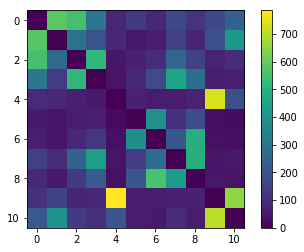

In [22]:
plt.imshow(n_good_matches)
plt.colorbar()

<font color='red'> not necessarily symmetric

## Determine initial pairs

In [111]:
ind = np.unravel_index(np.argmax(n_good_matches, axis=None), n_good_matches.shape)
ind

(9, 4)

In [112]:
img1,img2=images[9],images[4]
good_match=good_matches[9][4]

In [113]:
pts1,pts2=[],[]
for ele in good_match:
    pts1.append(keypoints[9][ele[0].queryIdx].pt)
    pts2.append(keypoints[4][ele[0].trainIdx].pt)

## two-view geometry

In [114]:
# compute F
pts1=np.int32(pts1)
pts2=np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)

In [115]:
F

array([[ 1.68771500e-08, -1.93441593e-07,  3.76900860e-04],
       [ 8.21741780e-07, -4.29827553e-08,  6.74085560e-03],
       [-1.08409369e-03, -7.93211400e-03,  1.00000000e+00]])

In [116]:
pts1.shape

(785, 2)

In [117]:
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [118]:
pts1.shape

(626, 2)

In [119]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

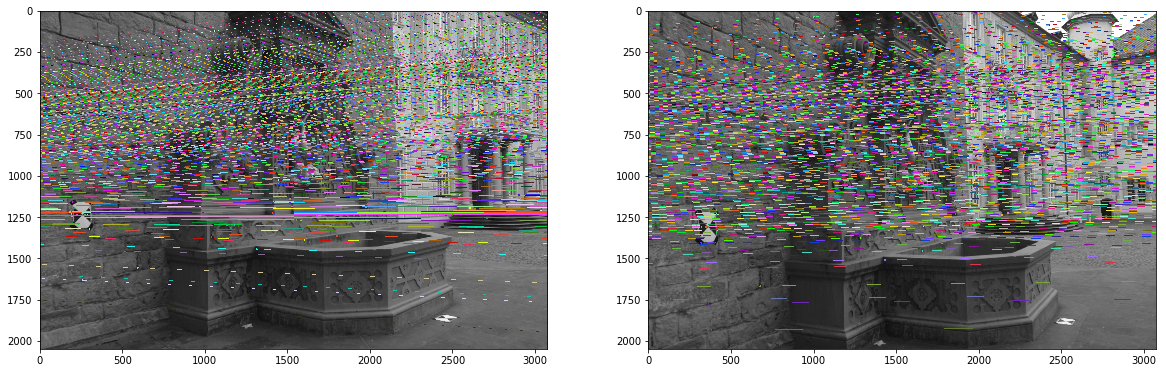

In [120]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [137]:
F

array([[ 1.68771500e-08, -1.93441593e-07,  3.76900860e-04],
       [ 8.21741780e-07, -4.29827553e-08,  6.74085560e-03],
       [-1.08409369e-03, -7.93211400e-03,  1.00000000e+00]])

In [123]:
K

array([[2.75948e+03, 0.00000e+00, 1.52069e+03],
       [0.00000e+00, 2.76416e+03, 1.00681e+03],
       [0.00000e+00, 0.00000e+00, 1.00000e+00]])

In [138]:
# recover essential matrix with F and K
E=np.dot(np.dot(K.T,F),K)

In [139]:
E

array([[  0.12851494,  -1.47550365,   0.57343883],
       [  6.26795395,  -0.3284132 ,  21.96731754],
       [ -0.63769081, -22.85837084,  -0.3173773 ]])

In [164]:
# linear triangulation
def linearTriangulation(P1,x1s,P2,x2s):
    XS=np.zeros((4,pts1.shape[0]))
    for k in range(pts1.shape[0]):
        r1=pts1[k,0]*P1[2,:]-P1[0,:]
        r2=pts1[k,1]*P1[2,:]-P1[1,:]
        r3=pts2[k,0]*P2[2,:]-P2[0,:]
        r4=pts2[k,1]*P2[2,:]-P2[1,:]
        
        A=np.vstack((r1,r2,r3,r4))
        U,S,Vh=np.linalg.svd(A)
        XS[:,k]=Vh.T[:,-1]/Vh.T[3,3]
    return XS

In [197]:
def determineP(Ps,K,pts1,pts2):
    if(pts1.shape[1]==2):
        pts1=np.hstack((pts1,np.ones((pts1.shape[0],1))))
    if(pts2.shape[1]==2):
        pts2=np.hstack((pts2,np.ones((pts2.shape[0],1))))
        
    normalized_pts1=np.dot(np.linalg.inv(K),pts1.T).T
    normalized_pts2=np.dot(np.linalg.inv(K),pts2.T).T
    
    inliers_count=[]
    ind_inliers=[]
    P=np.eye(4)
    for proj_mat in Ps:
        X=linearTriangulation(P,normalized_pts1,proj_mat,normalized_pts2)
        p1X=X
        p2X=np.dot(proj_mat,X)
        
        n1_infront=(p1X[2,:]>0).sum()
        n2_infront=(p2X[2,:]>0).sum()
        
        ind_inliers.append(np.logical_and(p1X[2,:]>0,p2X[2,:]>0))
        inliers_count.append(n1_infront+n2_infront)
    inliers_count=np.array(inliers_count)
    ind_proj=inliers_count.argmax()
    ind_inlier=ind_inliers[ind_proj]
    
    proj_mat=Ps[ind_proj]
    Xs=linearTriangulation(P,normalized_pts1[ind_inlier],proj_mat,normalized_pts2[ind_inlier])
    
    return proj_mat,Xs

In [198]:
def decomposeE(E,pts1,pts2):
    W=np.array([[0,-1,0],[1,0,0],[0,0,1]])
    [U,S,Vh]=np.linalg.svd(E) # U and Vh is normalized
    
    # extract translation
    t=U[:,2].reshape((-1,1))
    
    # extraction rotation
    R1=np.dot(np.dot(U,W),Vh)
    R2=np.dot(np.dot(U,W.T),Vh)
    if(np.linalg.det(R1)<0):
        R1=-R1
    if(np.linalg.det(R2)<0):
        R2=-R2
        
    # four possible projection matrice
    P1=np.vstack((np.hstack((R1,t)),np.array([0,0,0,1])))
    P2=np.vstack((np.hstack((R1,-t)),np.array([0,0,0,1])))
    P3=np.vstack((np.hstack((R2,t)),np.array([0,0,0,1])))
    P4=np.vstack((np.hstack((R2,-t)),np.array([0,0,0,1])))
    Ps=[P1,P2,P3,P4]
    
    proj_mat,Xs=determineP(Ps,K,pts1,pts2)
    return proj_mat,Xs

In [199]:
proj_mat,Xs=decomposeE(E,pts1,pts2)

In [200]:
Xs.shape

(4, 626)

In [214]:
import ipympl
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs[0,:], Xs[1,:], Xs[2,:])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …